In [2]:
!python --version

Python 3.10.18


In [3]:
import torch
torch.__version__

'2.5.1+cu121'

In [4]:
torch.cuda.get_device_name(0)


'NVIDIA RTX 5000 Ada Generation'

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # Get all image file paths from the directory
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Apply the transform if provided
        if self.transform:
            image = self.transform(image)
        
        return image

In [26]:
# defining thw ransformations

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
])

dataset_path = '/data1/adarsh/CELEB_FACE_DATASET/img_align_celeba'
dataset = CelebADataset(root_dir = dataset_path,transform = transform)

dataloader = DataLoader(dataset,batch_size = 128,shuffle = True,pin_memory=True,num_workers=4)

print(f"Total num of imag loaded:{len(dataset)}")

Total num of imag loaded:202599


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import torchvision
import numpy as np


In [21]:
class DCGANGenerator(nn.Module):
    def __init__(self,z_dim = 100,img_channels = 3,feature_map = 64):
        super(DCGANGenerator,self).__init__()
        self.net = nn.Sequential(
            # input zdim x 1 X  1
            nn.ConvTranspose2d(z_dim,feature_map*8,kernel_size=4,stride=1,bias=False),
            nn.BatchNorm2d(feature_map*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map*8,feature_map*4,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(feature_map*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map*4,feature_map*2,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(feature_map*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map*2,feature_map,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(feature_map),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(feature_map,img_channels,4,2,1,bias=False),
            nn.Tanh()

        )    

    def forward(self,z):
        z = z.view(z.size(0),z.size(1),1,1)
        return self.net(z)    
        
            
        

    

In [17]:
class DCGANDiscriminator(nn.Module):
    def __init__(self,img_channels = 3,feature_map = 64):
        super(DCGANDiscriminator,self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels,feature_map,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(feature_map,feature_map*2,4,2,1,bias=False),
            nn.BatchNorm2d(feature_map*2),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(feature_map*2,feature_map*4,4,2,1,bias=False),
            nn.BatchNorm2d(feature_map*4),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(feature_map*4,feature_map*8,4,2,1,bias=False),
            nn.BatchNorm2d(feature_map*8),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(feature_map*8,1,4,1,0,bias=False),
            nn.Sigmoid()



        )

    def forward(self,x):
        return self.net(x).view(-1,1)
        

In [22]:
# Loss function and optimiser

adversarial_loss = nn.BCELoss()
generator = DCGANGenerator(z_dim = 100)
discriminator = DCGANDiscriminator()

optimizer_G = optim.Adam(generator.parameters(),lr = 0.0002,betas = (0.5,0.999))
optimizer_D = optim.Adam(discriminator.parameters(),lr = 0.0002,betas = (0.5,0.999))


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

In [12]:
def save_generated_images(generator, epoch, device, num_images=16, image_dir="generated_images"):
    os.makedirs(image_dir, exist_ok=True)  # ensure folder exists

    # sample noise
    z = torch.randn(num_images, 100).to(device)
    generated_imgs = generator(z).detach().cpu()

    # save in local directory
    save_path = os.path.join(image_dir, f"epoch_{epoch+1}.png")
    torchvision.utils.save_image(
        generated_imgs, 
        save_path,
        nrow=4, normalize=True
    )
    print(f"Saved generated images at: {save_path}")

    # show inline (optional during training)
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=True)
    plt.figure(figsize=(6, 6))   # better scaling
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(f"Epoch {epoch+1}")
    plt.axis('off')
    plt.show()


In [33]:
import os
import torch

# Directories
checkpoint_dir = "model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(generator, discriminator, optimizer_G, optimizer_D, epoch, max_keep=5):
    """Save model checkpoints and keep only the last 'max_keep' files."""
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
    
    # Save both Generator & Discriminator states
    torch.save({
        'epoch': epoch+1,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
    }, checkpoint_path)

    # Manage only last max_keep checkpoints
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")]
    # Sort numerically by epoch number
    checkpoints = sorted(checkpoints, key=lambda x: int(x.split("_")[-1].split(".")[0]))
    
    # Remove oldest if exceeding max_keep
    while len(checkpoints) > max_keep:
        os.remove(os.path.join(checkpoint_dir, checkpoints[0]))
        checkpoints.pop(0)


In [32]:
# Resume training if checkpoint exists
def load_latest_checkpoint(generator, discriminator, optimizer_G, optimizer_D, checkpoint_dir="model_checkpoints"):
    if not os.path.exists(checkpoint_dir):
        return 0  # start from epoch 0
    
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")]
    if len(checkpoints) == 0:
        return 0  # no checkpoints found
    
    # Sort numerically by epoch number
    checkpoints = sorted(checkpoints, key=lambda x: int(x.split("_")[-1].split(".")[0]))
    
    latest_checkpoint = checkpoints[-1]  # now this is truly the latest epoch
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    print(f"Loading checkpoint: {checkpoint_path}")
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    
    return checkpoint['epoch']  # return the last trained epoch



In [29]:
def train(generator,discriminator,dataloader,epochs = 10):
    start_epoch = load_latest_checkpoint(generator, discriminator, optimizer_G, optimizer_D)
    for epoch in range(start_epoch,epochs):
        for i , imgs in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batch_size = real_imgs.size(0)
            valid = torch.ones(batch_size,1).to(device)
            fake = torch.zeros(batch_size,1).to(device)

            # train discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs),valid)
            fake_loss = adversarial_loss(discriminator(generator(torch.randn(batch_size,100).to(device)).detach()),fake)
            d_loss = (real_loss + fake_loss)/2
            d_loss.backward()
            optimizer_D.step()

            # Training the generator 
            optimizer_G.zero_grad()
            g_loss = adversarial_loss(discriminator(generator(torch.randn(batch_size,100).to(device))),valid)
            g_loss.backward()
            optimizer_G.step()

            if i%100 ==0:
                print(f"[Epochs {epoch+1}/{epochs}] [Batch {i}/{len(dataloader)}] [D_loss : {d_loss.item()}] [G_loss : {g_loss.item()}]")

        save_generated_images(generator, epoch, device)
        # At the end of epoch
        save_checkpoint(generator, discriminator,optimizer_G,optimizer_D, epoch, max_keep=2)



    

Loading checkpoint: model_checkpoints/checkpoint_epoch_2.pth


/tmp/ipykernel_145321/1484845189.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


[Epochs 3/100] [Batch 0/1583] [D_loss : 0.09492500126361847] [G_loss : 3.8407208919525146]
[Epochs 3/100] [Batch 100/1583] [D_loss : 0.3057962954044342] [G_loss : 2.4733400344848633]
[Epochs 3/100] [Batch 200/1583] [D_loss : 0.11547538638114929] [G_loss : 3.108889579772949]
[Epochs 3/100] [Batch 300/1583] [D_loss : 0.26018229126930237] [G_loss : 2.055907726287842]
[Epochs 3/100] [Batch 400/1583] [D_loss : 0.18568652868270874] [G_loss : 3.8315320014953613]
[Epochs 3/100] [Batch 500/1583] [D_loss : 0.49919360876083374] [G_loss : 6.24737548828125]
[Epochs 3/100] [Batch 600/1583] [D_loss : 0.26150602102279663] [G_loss : 3.716031789779663]
[Epochs 3/100] [Batch 700/1583] [D_loss : 0.14041419327259064] [G_loss : 2.67155385017395]
[Epochs 3/100] [Batch 800/1583] [D_loss : 0.37225306034088135] [G_loss : 3.6569089889526367]
[Epochs 3/100] [Batch 900/1583] [D_loss : 0.0850769579410553] [G_loss : 2.4342093467712402]
[Epochs 3/100] [Batch 1000/1583] [D_loss : 0.47090470790863037] [G_loss : 5.29850

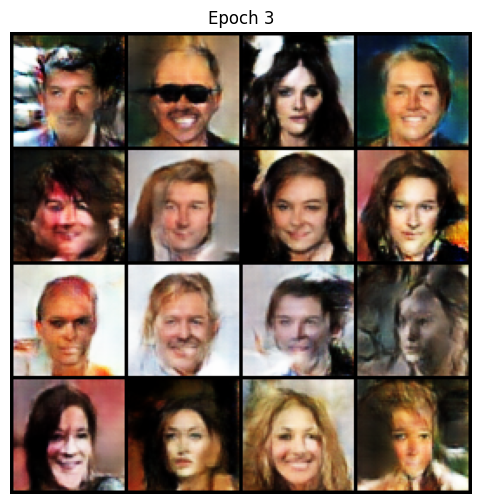

[Epochs 4/100] [Batch 0/1583] [D_loss : 0.18002699315547943] [G_loss : 5.530489921569824]
[Epochs 4/100] [Batch 100/1583] [D_loss : 0.6034507155418396] [G_loss : 7.385213851928711]
[Epochs 4/100] [Batch 200/1583] [D_loss : 0.4011734127998352] [G_loss : 7.8322296142578125]
[Epochs 4/100] [Batch 300/1583] [D_loss : 0.18043091893196106] [G_loss : 3.7469239234924316]
[Epochs 4/100] [Batch 400/1583] [D_loss : 1.6771451234817505] [G_loss : 0.4147293269634247]
[Epochs 4/100] [Batch 500/1583] [D_loss : 1.2006244659423828] [G_loss : 5.984704971313477]
[Epochs 4/100] [Batch 600/1583] [D_loss : 0.11542782187461853] [G_loss : 3.6941161155700684]
[Epochs 4/100] [Batch 700/1583] [D_loss : 0.2893317639827728] [G_loss : 1.413090467453003]
[Epochs 4/100] [Batch 800/1583] [D_loss : 0.11442339420318604] [G_loss : 3.1264922618865967]
[Epochs 4/100] [Batch 900/1583] [D_loss : 0.3397316634654999] [G_loss : 1.064176082611084]
[Epochs 4/100] [Batch 1000/1583] [D_loss : 0.05887826532125473] [G_loss : 3.7632620

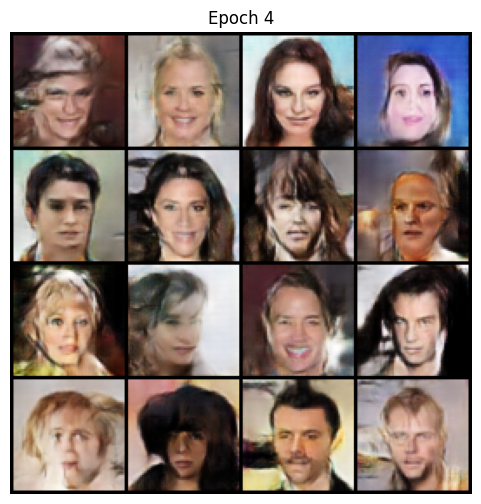

[Epochs 5/100] [Batch 0/1583] [D_loss : 0.15900976955890656] [G_loss : 4.58402681350708]
[Epochs 5/100] [Batch 100/1583] [D_loss : 0.11629383265972137] [G_loss : 3.636335849761963]
[Epochs 5/100] [Batch 200/1583] [D_loss : 0.1550687998533249] [G_loss : 3.097104072570801]
[Epochs 5/100] [Batch 300/1583] [D_loss : 0.12425486743450165] [G_loss : 4.34912109375]
[Epochs 5/100] [Batch 400/1583] [D_loss : 0.6944662928581238] [G_loss : 1.5241761207580566]
[Epochs 5/100] [Batch 500/1583] [D_loss : 0.09736401587724686] [G_loss : 3.5706043243408203]
[Epochs 5/100] [Batch 600/1583] [D_loss : 0.07423156499862671] [G_loss : 3.791551113128662]
[Epochs 5/100] [Batch 700/1583] [D_loss : 0.24538841843605042] [G_loss : 2.6841344833374023]
[Epochs 5/100] [Batch 800/1583] [D_loss : 0.15197044610977173] [G_loss : 3.3402185440063477]
[Epochs 5/100] [Batch 900/1583] [D_loss : 0.10119965672492981] [G_loss : 4.662204265594482]
[Epochs 5/100] [Batch 1000/1583] [D_loss : 0.06483659148216248] [G_loss : 3.240545272

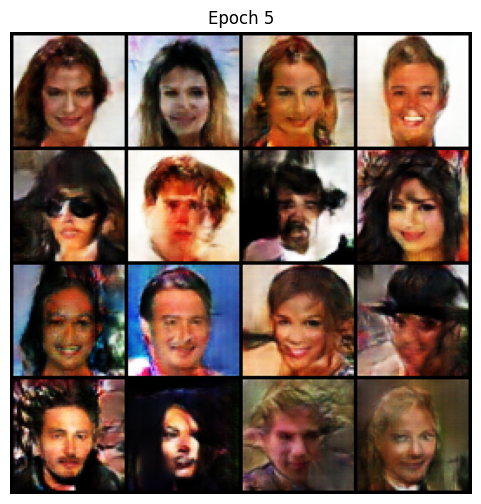

[Epochs 6/100] [Batch 0/1583] [D_loss : 0.2233445942401886] [G_loss : 5.388598442077637]
[Epochs 6/100] [Batch 100/1583] [D_loss : 0.0882222130894661] [G_loss : 3.549001693725586]
[Epochs 6/100] [Batch 200/1583] [D_loss : 0.2569683790206909] [G_loss : 2.8546786308288574]
[Epochs 6/100] [Batch 300/1583] [D_loss : 0.04866592586040497] [G_loss : 3.7985289096832275]
[Epochs 6/100] [Batch 400/1583] [D_loss : 0.0670194923877716] [G_loss : 3.8030600547790527]
[Epochs 6/100] [Batch 500/1583] [D_loss : 0.06766144931316376] [G_loss : 3.668382167816162]
[Epochs 6/100] [Batch 600/1583] [D_loss : 0.1128210574388504] [G_loss : 4.5311479568481445]
[Epochs 6/100] [Batch 700/1583] [D_loss : 0.6001615524291992] [G_loss : 5.463411808013916]
[Epochs 6/100] [Batch 800/1583] [D_loss : 1.8906251192092896] [G_loss : 1.7594842910766602]
[Epochs 6/100] [Batch 900/1583] [D_loss : 0.06505712866783142] [G_loss : 4.065821647644043]
[Epochs 6/100] [Batch 1000/1583] [D_loss : 0.04779092222452164] [G_loss : 4.10425949

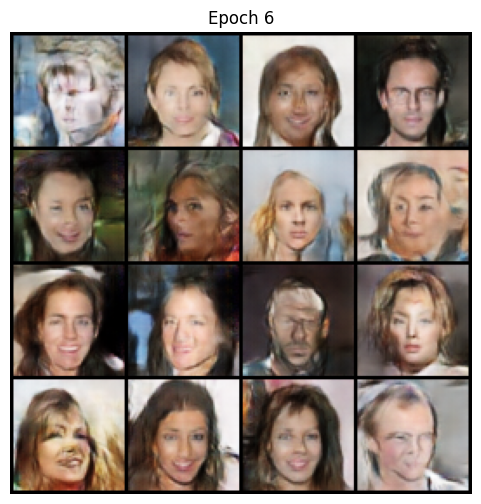

[Epochs 7/100] [Batch 0/1583] [D_loss : 0.1160813570022583] [G_loss : 3.3970448970794678]
[Epochs 7/100] [Batch 100/1583] [D_loss : 2.8751120567321777] [G_loss : 8.453788757324219]
[Epochs 7/100] [Batch 200/1583] [D_loss : 0.30409207940101624] [G_loss : 5.275392532348633]
[Epochs 7/100] [Batch 300/1583] [D_loss : 0.07122164964675903] [G_loss : 3.2950830459594727]
[Epochs 7/100] [Batch 400/1583] [D_loss : 0.04839097708463669] [G_loss : 3.3327972888946533]
[Epochs 7/100] [Batch 500/1583] [D_loss : 0.10338225215673447] [G_loss : 4.970283508300781]
[Epochs 7/100] [Batch 600/1583] [D_loss : 0.043222181499004364] [G_loss : 4.175417423248291]
[Epochs 7/100] [Batch 700/1583] [D_loss : 0.11281853169202805] [G_loss : 3.947615623474121]
[Epochs 7/100] [Batch 800/1583] [D_loss : 0.4129045009613037] [G_loss : 1.740918517112732]
[Epochs 7/100] [Batch 900/1583] [D_loss : 0.08040369302034378] [G_loss : 5.553434371948242]
[Epochs 7/100] [Batch 1000/1583] [D_loss : 0.03896097466349602] [G_loss : 3.93718

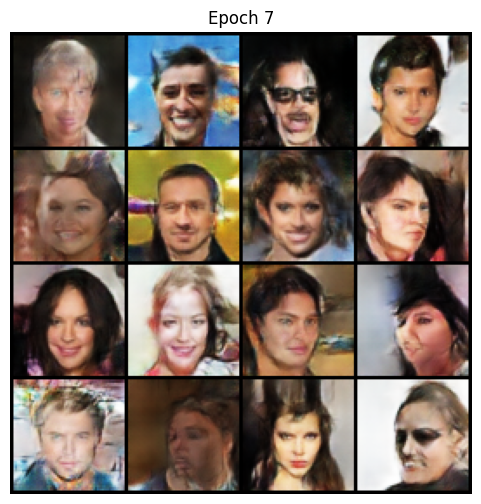

[Epochs 8/100] [Batch 0/1583] [D_loss : 1.210208535194397] [G_loss : 9.592723846435547]
[Epochs 8/100] [Batch 100/1583] [D_loss : 0.07608670741319656] [G_loss : 3.4542322158813477]
[Epochs 8/100] [Batch 200/1583] [D_loss : 0.18474288284778595] [G_loss : 2.008017063140869]
[Epochs 8/100] [Batch 300/1583] [D_loss : 0.0954061970114708] [G_loss : 4.682514667510986]
[Epochs 8/100] [Batch 400/1583] [D_loss : 0.03774133697152138] [G_loss : 3.6388981342315674]
[Epochs 8/100] [Batch 500/1583] [D_loss : 0.09890572726726532] [G_loss : 4.571606159210205]
[Epochs 8/100] [Batch 600/1583] [D_loss : 0.05798187106847763] [G_loss : 3.9532699584960938]
[Epochs 8/100] [Batch 700/1583] [D_loss : 0.13559310138225555] [G_loss : 3.526202917098999]
[Epochs 8/100] [Batch 800/1583] [D_loss : 0.035210248082876205] [G_loss : 3.7770142555236816]
[Epochs 8/100] [Batch 900/1583] [D_loss : 0.07623215764760971] [G_loss : 4.806764602661133]
[Epochs 8/100] [Batch 1000/1583] [D_loss : 1.3208441734313965] [G_loss : 1.00191

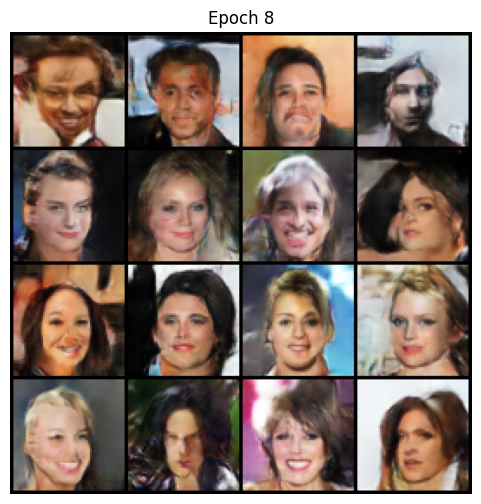

[Epochs 9/100] [Batch 0/1583] [D_loss : 2.5025441646575928] [G_loss : 0.28355932235717773]
[Epochs 9/100] [Batch 100/1583] [D_loss : 0.17298847436904907] [G_loss : 3.3610386848449707]
[Epochs 9/100] [Batch 200/1583] [D_loss : 0.0763411596417427] [G_loss : 4.3769073486328125]
[Epochs 9/100] [Batch 300/1583] [D_loss : 0.03949742764234543] [G_loss : 4.166083335876465]
[Epochs 9/100] [Batch 400/1583] [D_loss : 0.08354673534631729] [G_loss : 3.725466251373291]
[Epochs 9/100] [Batch 500/1583] [D_loss : 0.2760893404483795] [G_loss : 7.159504413604736]
[Epochs 9/100] [Batch 600/1583] [D_loss : 0.058972060680389404] [G_loss : 3.2038893699645996]
[Epochs 9/100] [Batch 700/1583] [D_loss : 0.06480799615383148] [G_loss : 3.4311556816101074]
[Epochs 9/100] [Batch 800/1583] [D_loss : 0.05752214416861534] [G_loss : 4.927055358886719]
[Epochs 9/100] [Batch 900/1583] [D_loss : 0.03641362488269806] [G_loss : 5.393392562866211]
[Epochs 9/100] [Batch 1000/1583] [D_loss : 0.05457603931427002] [G_loss : 4.09

KeyboardInterrupt: 

In [34]:
# Start training
train(generator, discriminator, dataloader, epochs=100)